In [123]:
import pandas as pd
import numpy as np
import os
# acquire
from env import host, user, password
from pydataset import data

# visualize
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(11, 9))
plt.rc('font', size=13)

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.preprocessing

#docs
import acquire
import prepare_zillow

# Exercises

## Acquire (acquire.py)
- Zillow
- For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

- You will have a zillow.ipynb file and a helper file for each section in the pipeline.

- acquire & summarize




1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

    - Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
    - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.
    - Only include properties that include a latitude and longitude value.
    


In [2]:
zillow_df= acquire.new_zillow_data()

In [3]:
zillow_df.head() #looking at first 5 values

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,buildingclasstypeid,buildingclassdesc,heatingorsystemtypeid,heatingorsystemdesc,buildingclasstypeid,buildingclassdesc,storytypeid,storydesc,typeconstructiontypeid,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,NaN,None,2.0,Central,NaN,None,NaN,None,NaN,None
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,NaN,None,2.0,Central,NaN,None,NaN,None,NaN,None


In [4]:
#looking at shape before dropping duplicate columns
zillow_df.shape

(77579, 79)

In [5]:
#Looking at list of columns
zillow_df.columns.to_list()

['id',
 'parcelid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',


In [6]:
#drop duplicate columns
zillow_df= zillow_df.loc[:, ~zillow_df.columns.duplicated()]

In [7]:
#verify duplicate columns were dropped (went from 79 to 68 columns)
zillow_df.shape

(77579, 68)

In [8]:
#making sure there is only one parcelid column
zillow_df['parcelid']

0        14297519
1        17052889
2        14186244
3        12177905
4        10887214
           ...   
77574    10833991
77575    11000655
77576    17239384
77577    12773139
77578    12826780
Name: parcelid, Length: 77579, dtype: int64

In [9]:
#making sure there is only one id column
zillow_df['id']

0        1727539
1        1387261
2          11677
3        2288172
4        1970746
          ...   
77574    2864704
77575     673515
77576    2968375
77577    1843709
77578    1187175
Name: id, Length: 77579, dtype: int64

In [10]:
#filter by parcel and max transaction date
zillow_df= zillow_df.groupby(by= 'parcelid').max('transaction')

In [11]:
#functions
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    print(type(num_missing))
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing

def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return rows_missing

In [12]:
#using functions
nulls_by_col(zillow_df)

<class 'pandas.core.series.Series'>


,num_rows_missing,percent_rows_missing
id,0,0.000000
airconditioningtypeid,52428,67.753066
architecturalstyletypeid,77175,99.733785
basementsqft,77331,99.935385
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
buildingclasstypeid,77366,99.980615
buildingqualitytypeid,27709,35.808532
calculatedbathnbr,609,0.787015
decktypeid,76767,99.206524


In [13]:
nulls_by_row(zillow_df)

,num_cols_missing,percent_cols_missing,parcelid
0,17,30.357142857142854,2
1,18,32.142857142857146,10
2,19,33.92857142857143,79
3,20,35.714285714285715,264
4,21,37.5,423
5,22,39.285714285714285,444
6,23,41.07142857142857,1194
7,24,42.857142857142854,7188
8,25,44.642857142857146,8686
9,26,46.42857142857143,11856


In [14]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # value_counts()
    # observation of nulls in the dataframe
    '''
    print('=====================================================')
    print('Dataframe head: ')
    print(df.head(3))
    print('=====================================================')
    print('Dataframe info: ')
    print(df.info())
    print('=====================================================')
    print('Dataframe Description: ')
    print(df.describe())
    num_cols = [col for col in df.columns if df[col].dtype != 'O']
    cat_cols = [col for col in df.columns if col not in num_cols]
    print('=====================================================')
    print('DataFrame value counts: ')
    for col in df.columns:
        if col in cat_cols:
            print(df[col].value_counts())  
        else:
            print(df[col].value_counts(bins=10, sort=False))
            print('=====================================================')
            
    print('=====================================================')
    print('nulls in dataframe by column: ')
    print(nulls_by_col(df))
    print('=====================================================')
    print('nulls in dataframe by row: ')
    print(nulls_by_row(df))
    print('=====================================================')

In [15]:
summarize(zillow_df)

Dataframe head: 
               id  airconditioningtypeid  architecturalstyletypeid  \
parcelid                                                             
10711855  1087254                    NaN                       NaN   
10711877  1072280                    1.0                       NaN   
10711888  1340933                    1.0                       NaN   

          basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
parcelid                                                               
10711855           NaN          2.0         3.0                  NaN   
10711877           NaN          2.0         4.0                  NaN   
10711888           NaN          2.0         4.0                  NaN   

          buildingqualitytypeid  calculatedbathnbr  decktypeid  ...  \
parcelid                                                        ...   
10711855                    8.0                2.0         NaN  ...   
10711877                    8.0                2.0        

In [16]:
#Looking at shape
zillow_df.shape

(77381, 56)

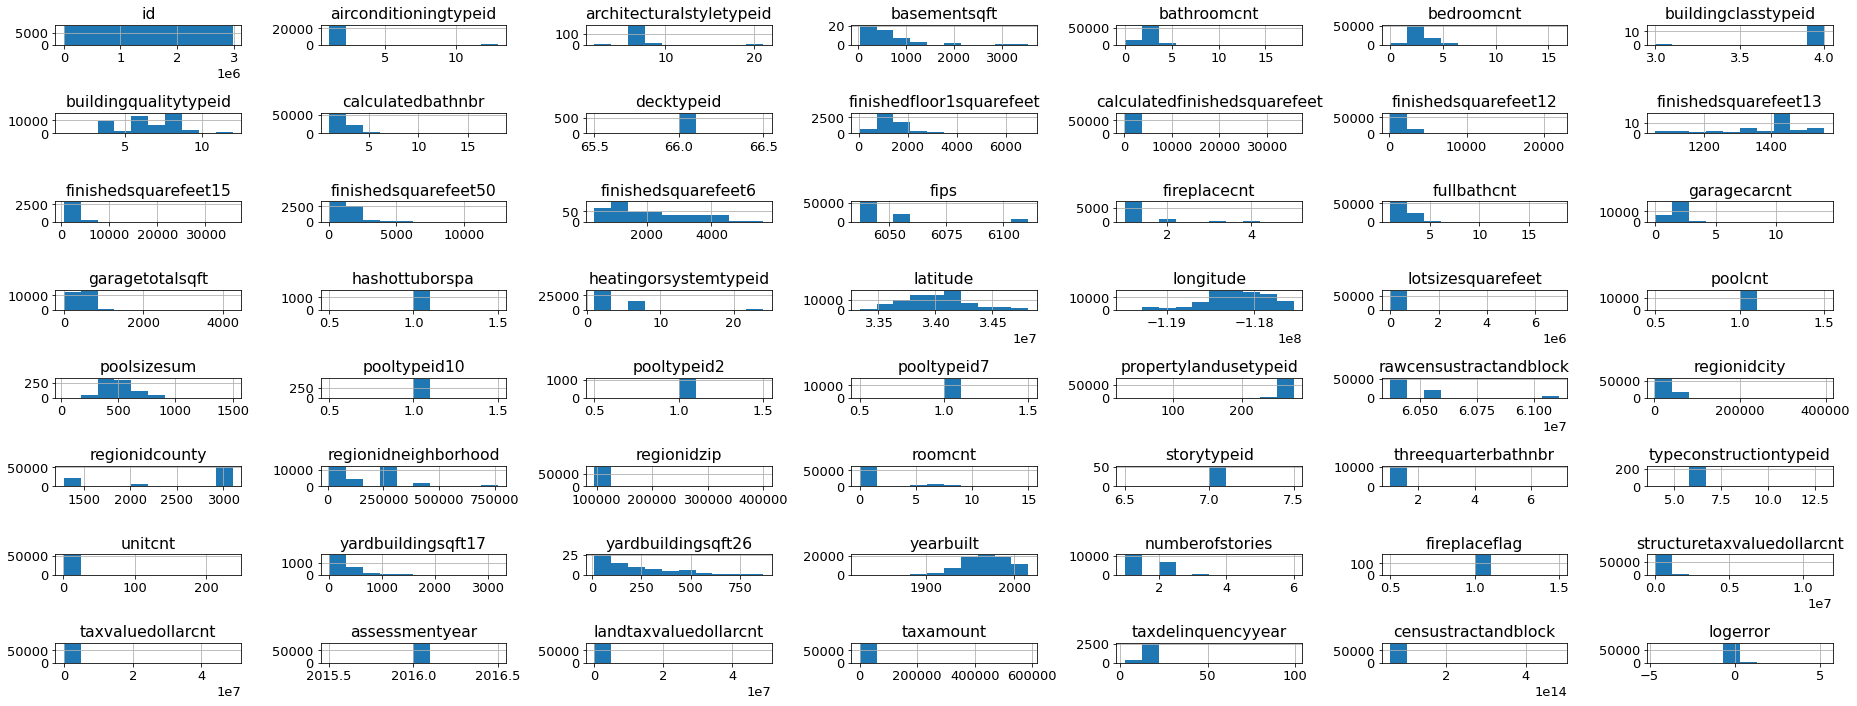

In [17]:
zillow_df.hist(figsize=(26, 10))
plt.tight_layout()
plt.show()

3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values

In [98]:
def missing_dup_values(df):
    '''
    this function takes a dataframe as input and will output metrics for missing values and duplicated rows,
    and the percent of that column that has missing values and duplicated rows
    '''
        # Total missing values
    mis_val = df.isnull().sum()
        # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        #total of duplicated
    dup = df.duplicated().sum()
        # Percentage of missing values
    dup_percent = 100 * dup / len(df)
        # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(mis_val_table_ren_columns.shape[0]) +
           " columns that have missing values.")
    print( "  ")
    print (f"** There are {dup} duplicate rows that represents {round(dup_percent, 2)}% of total Values**")
        # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [99]:
missing_dup_values(zillow_df)

Your selected dataframe has 56 columns.
There are 44 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
buildingclasstypeid,77366,100.0
finishedsquarefeet13,77340,99.9
basementsqft,77331,99.9
storytypeid,77331,99.9
yardbuildingsqft26,77311,99.9
fireplaceflag,77209,99.8
architecturalstyletypeid,77175,99.7
typeconstructiontypeid,77159,99.7
finishedsquarefeet6,76995,99.5
pooltypeid10,76917,99.4


4. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.

In [100]:
missing_dup_values(zillow_df)

Your selected dataframe has 56 columns.
There are 44 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
buildingclasstypeid,77366,100.0
finishedsquarefeet13,77340,99.9
basementsqft,77331,99.9
storytypeid,77331,99.9
yardbuildingsqft26,77311,99.9
fireplaceflag,77209,99.8
architecturalstyletypeid,77175,99.7
typeconstructiontypeid,77159,99.7
finishedsquarefeet6,76995,99.5
pooltypeid10,76917,99.4


- Prepare

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.


In [101]:
#defining single unit homes
prepare_df = zillow_df.loc[(zillow_df['bathroomcnt'] > 0) & (zillow_df['bathroomcnt'] <= 3) & (zillow_df['bedroomcnt'] > 0) & (zillow_df['bedroomcnt'] <= 5)]   
prepare_df.head(3)

,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,1087254,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,NaN,...,NaN,NaN,249655.0,624139.0,2016.0,374484.0,7659.36,NaN,6.037113e+13,-0.007357
10711877,1072280,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,NaN,...,NaN,NaN,253000.0,660000.0,2016.0,407000.0,8123.91,NaN,6.037113e+13,0.021066
10711888,1340933,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,NaN,...,NaN,NaN,257591.0,542923.0,2016.0,285332.0,6673.24,NaN,6.037113e+13,0.077174


In [102]:
#Looking at value counts
prepare_df.bedroomcnt.value_counts()

3.0    29422
2.0    19103
4.0    14744
1.0     3372
5.0     2418
Name: bedroomcnt, dtype: int64

2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

- The input:
- A dataframe
- A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
- A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
- The output:
    - The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
- hint:
    - Look up the dropna documentation.
    - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
    - Make use of inplace, i.e. inplace=True/False.
     


In [103]:
def handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.75):
    threshold = int(round(prop_required_columns * len(df.index),0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns),0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [104]:
prepare_df= handle_missing_values(zillow_df, prop_required_columns=0.5, prop_required_row=0.75)

In [105]:
#Look at first 5 values
prepare_df.head()

,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,...,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,1087254,2.0,3.0,8.0,2.0,2107.0,2107.0,6037.0,2.0,2.0,...,0.0,1.0,1972.0,249655.0,624139.0,2016.0,374484.0,7659.36,6.037113e+13,-0.007357
10711877,1072280,2.0,4.0,8.0,2.0,1882.0,1882.0,6037.0,2.0,2.0,...,0.0,1.0,1972.0,253000.0,660000.0,2016.0,407000.0,8123.91,6.037113e+13,0.021066
10711888,1340933,2.0,4.0,8.0,2.0,1882.0,1882.0,6037.0,2.0,2.0,...,0.0,1.0,1972.0,257591.0,542923.0,2016.0,285332.0,6673.24,6.037113e+13,0.077174
10711910,1878109,2.0,3.0,8.0,2.0,1477.0,1477.0,6037.0,2.0,2.0,...,0.0,1.0,1960.0,57968.0,78031.0,2016.0,20063.0,1116.46,6.037113e+13,-0.041238
10711923,2190858,2.0,4.0,8.0,2.0,1918.0,1918.0,6037.0,2.0,2.0,...,0.0,1.0,1960.0,167869.0,415459.0,2016.0,247590.0,5239.85,6.037113e+13,-0.009496


In [106]:
# looking at shape
prepare_df.shape

(77203, 28)

In [107]:
#Looking at amount of null values
prepare_df.isnull().sum()

id                                  0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           27532
calculatedbathnbr                 431
calculatedfinishedsquarefeet       18
finishedsquarefeet12             3454
fips                                0
fullbathcnt                       431
heatingorsystemtypeid           27763
latitude                            0
longitude                           0
lotsizesquarefeet                8157
propertylandusetypeid               0
rawcensustractandblock              0
regionidcity                     1459
regionidcounty                      0
regionidzip                        45
roomcnt                             0
unitcnt                         26640
yearbuilt                          87
structuretaxvaluedollarcnt         94
taxvaluedollarcnt                   1
assessmentyear                      0
landtaxvaluedollarcnt               1
taxamount                           5
censustracta

In [108]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[f'{col}'].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]
        
    return df

In [109]:
prepare_df = remove_outliers(prepare_df, 1.5, ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt'])

In [110]:
prepare_df.shape

(72173, 28)

3. Decide how to handle the remaining missing values:

    - Fill with constant value.
    - Impute with mean, median, mode.
    - Drop row/column

- wrangle_zillow.py
     - Functions of the work above needed to acquire and prepare a new sample of data.
     
     

In [111]:
prepare_df.isnull().sum()[prepare_df.isnull().sum()>0] # look at cols with nulls

buildingqualitytypeid         25291
calculatedbathnbr                15
finishedsquarefeet12           2494
fullbathcnt                      15
heatingorsystemtypeid         25140
lotsizesquarefeet              8023
regionidcity                   1290
regionidzip                      36
unitcnt                       24831
yearbuilt                        41
structuretaxvaluedollarcnt       72
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             1
taxamount                         5
censustractandblock             176
dtype: int64

In [112]:
prepare_df.columns.tolist()

['id',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fullbathcnt',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'logerror']

In [113]:
# value counts for cals with large amounts of nulls
for col in ['heatingorsystemtypeid', 'buildingqualitytypeid', 'unitcnt']:
    
    print(col)
    print(prepare_df[col].value_counts())

heatingorsystemtypeid
2.0     31346
7.0     13913
24.0      846
6.0       749
20.0       80
13.0       59
18.0       23
1.0        13
10.0        3
11.0        1
Name: heatingorsystemtypeid, dtype: int64
buildingqualitytypeid
8.0     14429
6.0     13202
4.0      9197
7.0      5364
5.0      2022
9.0      1689
11.0      482
3.0       317
10.0      111
12.0       40
1.0        21
2.0         8
Name: buildingqualitytypeid, dtype: int64
unitcnt
1.0    45035
2.0     1697
3.0      376
4.0      233
6.0        1
Name: unitcnt, dtype: int64


In [114]:
# dropping the columns with 16K missing values too much to fill/impute/drop rows

prepare_df = prepare_df.drop(columns=['heatingorsystemtypeid', 'buildingqualitytypeid', 'unitcnt'])

In [115]:
prepare_df.isnull().sum()[prepare_df.isnull().sum()>0] # look at remaining nulls

calculatedbathnbr               15
finishedsquarefeet12          2494
fullbathcnt                     15
lotsizesquarefeet             8023
regionidcity                  1290
regionidzip                     36
yearbuilt                       41
structuretaxvaluedollarcnt      72
taxvaluedollarcnt                1
landtaxvaluedollarcnt            1
taxamount                        5
censustractandblock            176
dtype: int64

In [116]:
# value counts for remaining cols that are descreet

for col in ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock']:
    
    print(col)
    print(prepare_df[col].value_counts())
    print()

calculatedbathnbr
2.0    31456
3.0    16840
1.0    12893
2.5     6569
4.0     2270
1.5     1408
3.5      722
Name: calculatedbathnbr, dtype: int64

fullbathcnt
2.0    38039
3.0    17561
1.0    14301
4.0     2257
Name: fullbathcnt, dtype: int64

regionidcity
12447.0     16635
46298.0      2500
5534.0       1841
54311.0      1803
40227.0      1534
            ...  
118880.0        5
13311.0         4
10815.0         3
21395.0         1
36078.0         1
Name: regionidcity, Length: 175, dtype: int64

regionidzip
97319.0    771
97318.0    695
96987.0    687
96993.0    584
97328.0    577
          ... 
96329.0      2
96039.0      2
96500.0      2
97092.0      1
97111.0      1
Name: regionidzip, Length: 387, dtype: int64

yearbuilt
1955.0    1927
1989.0    1657
1950.0    1627
1954.0    1544
1964.0    1544
1973.0    1513
1953.0    1506
1956.0    1404
1979.0    1367
1987.0    1359
1980.0    1334
1990.0    1281
1963.0    1260
1977.0    1223
1974.0    1215
1952.0    1211
1965.0    1208
1972.0   

In [117]:
# impute columns *do this after you split*

def impute(df, my_strategy, column_list):
    ''' take in a df, strategy, and cloumn list
        return df with listed columns imputed using input stratagy
    '''
        
    imputer = SimpleImputer(strategy=my_strategy)  # build imputer

    df[column_list] = imputer.fit_transform(df[column_list]) # fit/transform selected columns

    return df

In [118]:
prepare_df = impute(prepare_df, 'most_frequent', ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock'])

In [119]:
prepare_df.isnull().sum()[prepare_df.isnull().sum()>0] # look at remaining nulls

finishedsquarefeet12          2494
lotsizesquarefeet             8023
structuretaxvaluedollarcnt      72
taxvaluedollarcnt                1
landtaxvaluedollarcnt            1
taxamount                        5
dtype: int64

In [120]:
prepare_df = impute(prepare_df, 'median', ['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'])

In [121]:
prepare_df.isnull().sum()

id                              0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
dtype: int64

In [141]:
# Create helper function to get the necessary connection url.
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'



# Use the above helper function and a sql query in a single function.
def new_zillow_data():
    '''
    This function reads data from the Codeup db into a df.
    '''
    zillow_sql = ''' select * from properties_2017 as prop17
left join predictions_2017 as pred17 ON prop17.parcelid = pred17.parcelid
left join propertylandusetype as propland ON prop17.propertylandusetypeid = propland.propertylandusetypeid
left join airconditioningtype as actype ON prop17.airconditioningtypeid = actype.airconditioningtypeid
left join architecturalstyletype as arch ON prop17.architecturalstyletypeid = arch.architecturalstyletypeid
left join buildingclasstype as bc ON prop17.buildingclasstypeid = bc.buildingclasstypeid
left join heatingorsystemtype as heat ON prop17.heatingorsystemtypeid = heat.heatingorsystemtypeid
left join buildingclasstype as bct ON prop17.buildingclasstypeid = bct.buildingclasstypeid
left join storytype as st ON prop17.storytypeid = st.storytypeid
left join typeconstructiontype as tc ON prop17.typeconstructiontypeid = tc.typeconstructiontypeid
where (pred17.transactiondate Like '%2017%') and (prop17.longitude is not NULL) and (prop17.latitude is not NULL);
    '''
    return pd.read_sql(zillow_sql, get_connection('zillow'))


In [142]:
def get_zillow_data(cached=False):
    '''
    This function reads in zillow data from Codeup database and writes data to
    a csv file if cached == False or if cached == True reads in telco df from
    a csv file, returns df.
    '''
    if cached == False or os.path.isfile('zillow_df.csv') == False:
        
        # Read fresh data from db into a DataFrame.
        df = new_zillow_data()
        
        # Write DataFrame to a csv file.
        df.to_csv('zillow_df.csv')
        
    else:
        
        # If csv file exists or cached == True, read in data from csv.
        df = pd.read_csv('zillow_df.csv', index_col=0)
        
    return df

In [143]:
###############acquire#################


def get_connection(database, user=user, host=host, password=password):
    '''get URL with user, host, and password from env '''
    
    return f"mysql+pymysql://{user}:{password}@{host}/{database}"
    
    
def cache_sql_data(df, database):
    '''write dataframe to csv with title database_query.csv'''
    
    df.to_csv(f'{database}_query.csv',index = False)
        

def get_sql_data(database,query):
    ''' check if csv exists for the queried database
        if it does read from the csv
        if it does not create the csv then read from the csv  
    '''
    
    if os.path.isfile(f'{database}_query.csv') == False:   # check for the file
        
        df = pd.read_sql(query, get_connection(database))  # create file 
        
        cache_sql_data(df, database) # cache file
        
    return pd.read_csv(f'{database}_query.csv') # return contents of file


def get_zillow_data():
    ''' acquire zillow data'''
    
    query = '''

    select * 
    from predictions_2017

    left join properties_2017 using(parcelid)
    left join airconditioningtype using(airconditioningtypeid)
    left join architecturalstyletype using(architecturalstyletypeid)
    left join buildingclasstype using(buildingclasstypeid)
    left join heatingorsystemtype using(heatingorsystemtypeid)
    left join propertylandusetype using(propertylandusetypeid)
    left join storytype using(storytypeid)
    left join typeconstructiontype using(typeconstructiontypeid)

    where latitude is not null

    and longitude is not null

    '''

    database = "zillow"
    
    df = get_sql_data(database,query) # create/read csv for query
    
    df = df.sort_values('transactiondate').drop_duplicates('parcelid',keep='last') # drop duplicate parcelids keeping the latest
    
    return df 

#################################prepare###############################

def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[f'{col}'].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        return df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]  
    

def handle_missing_values(df, prop_required_column = .5, prop_required_row = .5):
    ''' 
        take in a dataframe and a proportion for columns and rows
        return dataframe with columns and rows not meeting proportions dropped
    '''
    col_thresh = int(round(prop_required_column*df.shape[0],0)) # calc column threshold
    
    df.dropna(axis=1, thresh=col_thresh, inplace=True) # drop columns with non-nulls less than threshold
    
    row_thresh = int(round(prop_required_row*df.shape[1],0))  # calc row threshhold
    
    df.dropna(axis=0, thresh=row_thresh, inplace=True) # drop columns with non-nulls less than threshold
    
    return df    
    
    
def impute(df, my_strategy, column_list):
    ''' take in a df strategy and cloumn list
        return df with listed columns imputed using input stratagy
    '''
        
    imputer = SimpleImputer(strategy=my_strategy)  # build imputer

    df[column_list] = imputer.fit_transform(df[column_list]) # fit/transform selected columns

    return df

def prepare_zillow(df):
    ''' Prepare Zillow Data'''
    
    # Restrict propertylandusedesc to those of single unit
    df = df[(df.propertylandusedesc == 'Single Family Residential') |
          (df.propertylandusedesc == 'Mobile Home') |
          (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes') |
          (df.propertylandusedesc == 'Townhouse')]
    
    # remove outliers in bed count, bath count, and area to better target single unit properties
    df = remove_outliers(df, 1.5, ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt'])
    
    # dropping cols/rows where more than half of the values are null
    df = handle_missing_values(df, prop_required_column = .5, prop_required_row = .5)
    
    # dropping the columns with 17K missing values too much to fill/impute/drop rows
    df = df.drop(columns=['heatingorsystemtypeid', 'buildingqualitytypeid', 'propertyzoningdesc', 'unitcnt', 'heatingorsystemdesc'])
    
    # imputing descreet columns with most frequent value
    df = impute(df, 'most_frequent', ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock'])
    
    # imputing continuous columns with median value
    df = impute(df, 'median', ['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'])
    
    return df

In [144]:
df = prepare_zillow(get_zillow_data())
df.head()

,propertylandusetypeid,parcelid,id,logerror,transactiondate,id.1,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,...,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertylandusedesc
0,261.0,14297519,0,0.025595,2017-01-01,1727539,3.5,4.0,3.5,3100.0,...,96978.0,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,Single Family Residential
1,261.0,17052889,1,0.055619,2017-01-01,1387261,1.0,2.0,1.0,1465.0,...,97099.0,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,Single Family Residential
2,261.0,14186244,2,0.005383,2017-01-01,11677,2.0,3.0,2.0,1243.0,...,97078.0,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,Single Family Residential
3,261.0,12177905,3,-0.103410,2017-01-01,2288172,3.0,4.0,3.0,2376.0,...,96330.0,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,Single Family Residential
6,261.0,12095076,6,-0.001011,2017-01-01,781532,3.0,4.0,3.0,2962.0,...,96293.0,0.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,Single Family Residential


## Mall Customers
### notebook
1. Acquire data from mall_customers.customers in mysql database.
2. Summarize data (include distributions and descriptive statistics).
3. Detect outliers using IQR.
4. Split data (train, validate, and test split).
5. Encode categorical columns using a one hot encoder (pd.get_dummies).
6. Handles missing values.
7. Scaling

- wrangle_mall.py
1. Acquire data from mall_customers.customers in mysql database.
2. Split the data into train, validate, and split
3. One-hot-encoding (pd.get_dummies)
4. Missing values
5. Scaling

In [59]:
# Create helper function to get the necessary connection url.
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'



# Use the above helper function and a sql query in a single function.


def get_mallcustomer_data():
    df = pd.read_sql('SELECT * FROM customers;', get_connection('mall_customers'))
    return df.set_index('customer_id')

In [60]:
mall_df= get_mallcustomer_data()

In [61]:
mall_df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [62]:
mall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [63]:
mall_df.describe()

,age,annual_income,spending_score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


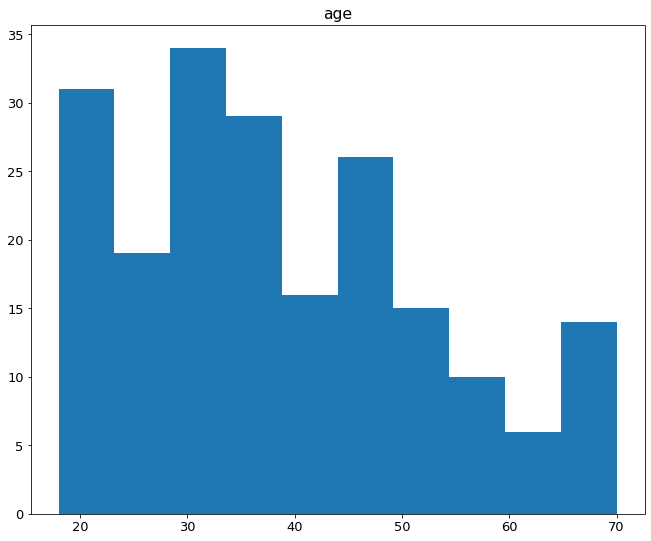

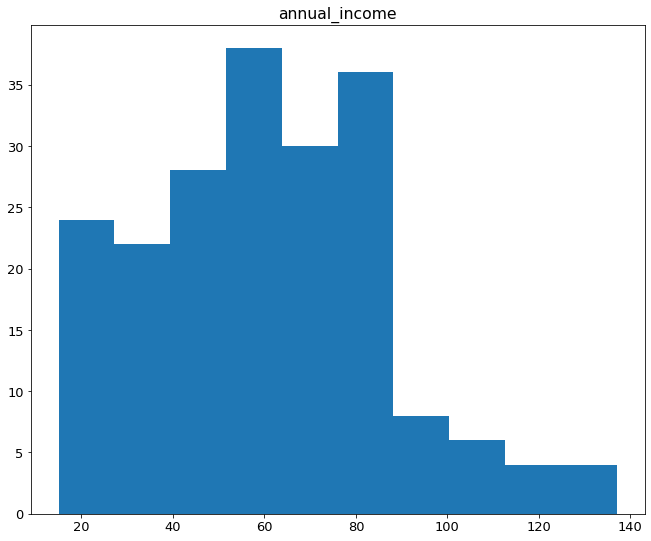

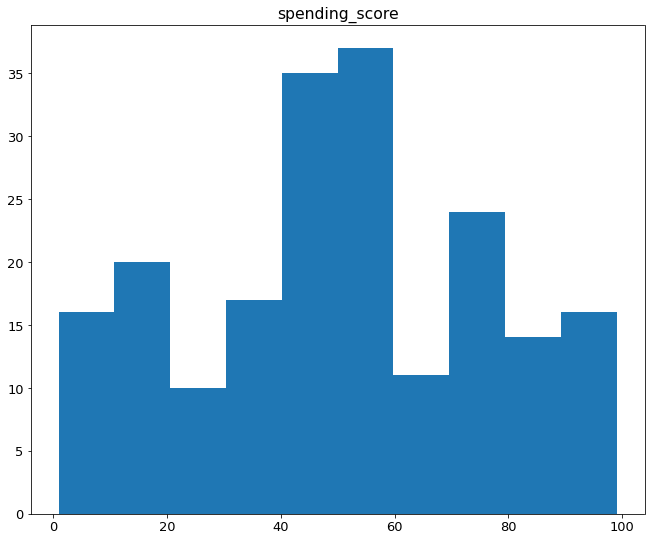

In [65]:
# distribution of the data
num_cols = ['age', 'annual_income', 'spending_score']

for col in num_cols:
    plt.hist(mall_df[col])
    plt.title(col)
    plt.show()


<AxesSubplot:title={'center':'spending_score distribution'}>

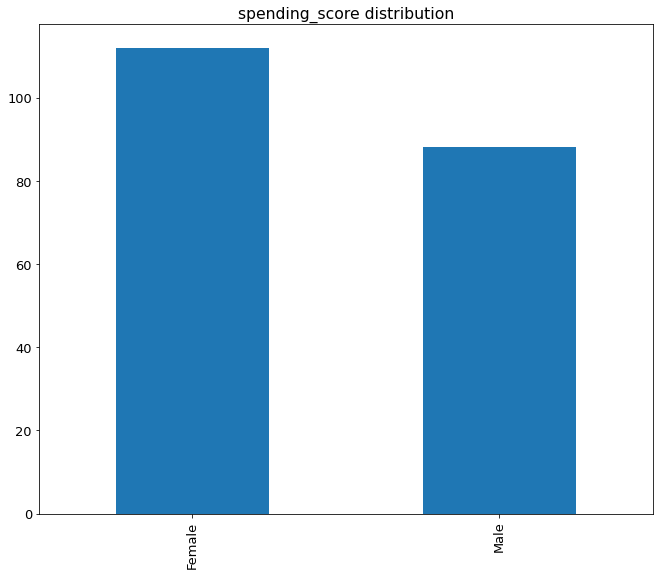

In [66]:
# vis 
mall_df['gender'].value_counts().plot(kind='bar', title = f"{col} distribution")

## Detect Outlier

In [67]:
mall_df.shape

(200, 4)

In [73]:
def detect_outliers(df, k, col_list):
    ''' get upper and lower bound for list of columns in a dataframe 
        if desired return that dataframe with the outliers removed
    '''
    
    odf = pd.DataFrame()
    
    for col in col_list:

        q1, q2, q3 = df[f'{col}'].quantile([.25, .5, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound
        
        # print each col and upper and lower bound for each column
        print(f"{col}: Median = {q2} lower_bound = {lower_bound} upper_bound = {upper_bound}")

        # return dataframe of outliers
        odf = odf.append(df[(df[f'{col}'] < lower_bound) | (df[f'{col}'] > upper_bound)])
            
    return odf

In [74]:
odf = detect_outliers(mall_df, 1.5,['age', 'annual_income', 'spending_score'])

age: Median = 36.0 lower_bound = -1.625 upper_bound = 79.375
annual_income: Median = 61.5 lower_bound = -13.25 upper_bound = 132.75
spending_score: Median = 50.0 lower_bound = -22.625 upper_bound = 130.375


In [75]:
odf

,gender,age,annual_income,spending_score
customer_id,,,,
199,Male,32,137,18
200,Male,30,137,83


## split data

In [77]:
def train_validate_test_split(df):
    '''split df into train, validate, test'''
    
    train, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    return train, validate, test

In [80]:
train, validate, test = train_validate_test_split(mall_df)

In [81]:
print(train.shape, validate.shape, test.shape)

(112, 4) (48, 4) (40, 4)


## Encode categorical columns using a one hot encoder (pd.get_dummies).

In [82]:
def encoding(df, cols, drop_first=True):
    '''
    Take in df and list of columns
    add encoded columns derived from columns in list to the df
    '''
    for col in cols:

        dummies = pd.get_dummies(df[f'{col}'], drop_first=drop_first) # get dummy columns

        df = pd.concat([df, dummies], axis=1) # add dummy columns to df
        
    return df


In [83]:
train = encoding(train, ['gender'], drop_first=True)
validate = encoding(validate, ['gender'], drop_first=True)
test = encoding(test, ['gender'], drop_first=True)

In [84]:
print(train.shape, validate.shape, test.shape)

(112, 5) (48, 5) (40, 5)


In [85]:
train.head()

,gender,age,annual_income,spending_score,Male
customer_id,,,,,
124,Male,39,69,91,1
77,Female,45,54,53,0
172,Male,28,87,75,1
11,Male,67,19,14,1
36,Female,21,33,81,0


## Handle missing values

In [86]:
mall_df.isna().sum() # number of missing values

gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

## Scaling

In [91]:
def min_max_scaling(train, validate, test, num_cols):
    '''
    Add scaled versions of a list of columns to train, validate, and test
    '''
    
    # reset index for merge 
    train = train.reset_index(drop=True)
    validate = validate.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    scaler = sklearn.preprocessing.MinMaxScaler() # create scaler object

    scaler.fit(train[num_cols]) # fit the object 

    # transform to get scaled columns
    train_scaled = pd.DataFrame(scaler.transform(train[num_cols]), columns = train[num_cols].columns + "_scaled")
    validate_scaled = pd.DataFrame(scaler.transform(validate[num_cols]), columns = validate[num_cols].columns + "_scaled")
    test_scaled = pd.DataFrame(scaler.transform(test[num_cols]), columns = test[num_cols].columns + "_scaled")
    
    # add scaled columns to dataframes
    train = train.merge(train_scaled, left_index=True, right_index=True)
    validate = validate.merge(validate_scaled, left_index=True, right_index=True)
    test = test.merge(train_scaled, left_index=True, right_index=True)
    
    return train, validate, test

In [92]:
train, validate, test = min_max_scaling(train, validate, test, ['age', 'annual_income', 'spending_score'])

In [93]:
print(train.shape, validate.shape, test.shape)

(112, 8) (48, 8) (40, 8)


In [94]:
train.head()

,gender,age,annual_income,spending_score,Male,age_scaled,annual_income_scaled,spending_score_scaled
0,Male,39,69,91,1,0.403846,0.442623,0.957447
1,Female,45,54,53,0,0.519231,0.319672,0.553191
2,Male,28,87,75,1,0.192308,0.590164,0.787234
3,Male,67,19,14,1,0.942308,0.032787,0.138298
4,Female,21,33,81,0,0.057692,0.147541,0.851064


In [95]:
validate.head()

,gender,age,annual_income,spending_score,Male,age_scaled,annual_income_scaled,spending_score_scaled
0,Male,19,48,59,1,0.019231,0.270492,0.617021
1,Female,52,88,13,0,0.653846,0.598361,0.127660
2,Female,32,48,47,0,0.269231,0.270492,0.489362
3,Female,49,65,59,0,0.596154,0.409836,0.617021
4,Female,24,20,77,0,0.115385,0.040984,0.808511


In [96]:
test.head()

,gender,age,annual_income,spending_score,Male,age_scaled,annual_income_scaled,spending_score_scaled
0,Female,49,42,52,0,0.403846,0.442623,0.957447
1,Male,40,71,95,1,0.519231,0.319672,0.553191
2,Female,30,34,73,0,0.192308,0.590164,0.787234
3,Male,34,78,90,1,0.942308,0.032787,0.138298
4,Female,35,23,98,0,0.057692,0.147541,0.851064


In [146]:
######################################acquire#####################################

def get_connection(database, user=user, host=host, password=password):
    '''get URL with user, host, and password from env '''
    
    return f"mysql+pymysql://{user}:{password}@{host}/{database}"
    

def get_sql_data(database,query):
    ''' 
        Take in a database and query
        check if csv exists for the queried database
        if it does read from the csv
        if it does not create the csv then read from the csv  
    '''
    
    if os.path.isfile(f'{database}_query.csv') == False:   # check for the file
        
        df = pd.read_sql(query, get_connection(database))  # create file 
        
        df.to_csv(f'{database}_query.csv',index = False)   # cache file
        
    return pd.read_csv(f'{database}_query.csv') # return contents of file


def get_mall_data():
    ''' acquire data from mall_customers database'''
    
    database = "mall_customers"

    query = "select * from customers"

    df = get_sql_data(database,query)
    
    return df

##################################Prepare##########################################

def detect_outliers(df, k, col_list, remove=False):
    ''' get upper and lower bound for list of columns in a dataframe 
        if desired return that dataframe with the outliers removed
    '''
    
    odf = pd.DataFrame()
    
    for col in col_list:

        q1, q2, q3 = df[f'{col}'].quantile([.25, .5, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound
        
        # print each col and upper and lower bound for each column
        print(f"{col}: Median = {q2} lower_bound = {lower_bound} upper_bound = {upper_bound}")

        # return dataframe of outliers
        odf = odf.append(df[(df[f'{col}'] < lower_bound) | (df[f'{col}'] > upper_bound)])
            
    return odf


def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[f'{col}'].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        return df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]  
    
    
def train_validate_test_split(df):
    '''split df into train, validate, test'''
    
    train, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    return train, validate, test


def min_max_scaling(train, validate, test, num_cols):
    '''
    Add scaled versions of a list of columns to train, validate, and test
    '''
    
    # reset index for merge 
    train = train.reset_index(drop=True)
    validate = validate.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    scaler = sklearn.preprocessing.MinMaxScaler() # create scaler object

    scaler.fit(train[num_cols]) # fit the object 

    # transform to get scaled columns
    train_scaled = pd.DataFrame(scaler.transform(train[num_cols]), columns = train[num_cols].columns + "_scaled")
    validate_scaled = pd.DataFrame(scaler.transform(validate[num_cols]), columns = validate[num_cols].columns + "_scaled")
    test_scaled = pd.DataFrame(scaler.transform(test[num_cols]), columns = test[num_cols].columns + "_scaled")
    
    # add scaled columns to dataframes
    train = train.merge(train_scaled, left_index=True, right_index=True)
    validate = validate.merge(validate_scaled, left_index=True, right_index=True)
    test = test.merge(train_scaled, left_index=True, right_index=True)
    
    return train, validate, test


def prepare_mall_data(df):
    ''' prepare mall data'''
    
    # split data
    train, validate, test = train_validate_test_split(df) 
       
    # encode gender in each column
    train = encoding(train, ['gender'], drop_first=True)
    validate = encoding(validate, ['gender'], drop_first=True)
    test = encoding(test, ['gender'], drop_first=True)
    
    # scale age, annual_income, and spending_score
    train, validate, test = min_max_scaling(train, validate, test,  ['age', 'annual_income', 'spending_score'])
    
    return train, validate, test

In [147]:
train, validate, test = prepare_mall_data(get_mall_data())

In [148]:
train.head()

,customer_id,gender,age,annual_income,spending_score,Male,age_scaled,annual_income_scaled,spending_score_scaled
0,124,Male,39,69,91,1,0.403846,0.442623,0.957447
1,77,Female,45,54,53,0,0.519231,0.319672,0.553191
2,172,Male,28,87,75,1,0.192308,0.590164,0.787234
3,11,Male,67,19,14,1,0.942308,0.032787,0.138298
4,36,Female,21,33,81,0,0.057692,0.147541,0.851064
